In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from random import shuffle

In [4]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [3]:
def prepare_data(images):
    X = np.zeros((len(images),ROWS, COLS, CHANNELS))
    Y = np.zeros( (len(images),1) )
    
    for i,fl in enumerate(images):
        
        img = Image.open(fl)
        img = img.resize((64,64))
        img_arr = np.array(img)
        img_arr = img_arr/255
        
        if( img_arr.shape == (64,64,3)):
            X[i,: ,:, :] = img_arr
        
        
        if 'dog' in fl.lower():
            Y[i,:] = 1
        else :
            Y[i,:] = 0
    return X,Y

In [13]:
def flatten(X):
    return X.reshape(X.shape[0],ROWS*COLS*CHANNELS ).T

In [14]:
def sigmoid(x):
    return 1/( 1+ np.exp(-x))

def relu(x):
    if(x>=0):
        return x
    else :
        return -1*x

In [15]:
#initialising weights and biases and returning as matrices
def init_para( n_x, n_h, n_y):
    
    w1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    
    w2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1":w1,
                  "b1":b1,
                  "W2":w2,
                  "b2":b2}
    return parameters

In [16]:
def forw_prop(X, parameters):
    w1 = parameters["W1"]
    b1 = parameters["b1"]
    w2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #following basic formulae for forw prop
    #matrix mutltiplication Z = node*weight + bias
    z1 = np.dot(w1, X) + b1
    
    #activation using relu
    a1 = np.tanh(z1)
    
    #node*weight + bias for the next layer
    z2 = np.dot(w2, a1) + b2
    #activation using sigmoid function
    a2 = sigmoid(z2)
    
    
    
    temp = {"z1":z1,
            "a1":a1,
            "z2":z2,
            "a2":a2}
    
    return a2, temp

In [17]:
def what_is_cost(a2, Y, parameters):
    #gives number of rows of output layer in m
    m = Y.shape[1] #turns out to be 1
    
    #cost is calculated using some complicated looking formula
    #cost basically gives us how good/bad the model has got after training iterations
    #basically calcs error compared to the Y
    v = np.multiply(np.log(a2), Y) + np.multiply((1-Y),np.log(1-a2))
    
    cost = (-1/m)*np.sum(v)
    
    return cost

In [18]:
def back_prop(parameters, temp, X, Y, m):
    
    
    w1 = parameters["W1"]
    w2 = parameters["W2"]
    a1 = temp["a1"]
    a2 = temp["a2"]
    
    
    
    #explaination
    #dz2(n_y,m)
    dz2 = a2 - Y
    
    #dw2(n_y,n_h)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    
    #db2(n_y,1) = 1,1
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    #dz1(n_h,1)
    dz1 = np.dot( w2.T, dz2)*(1 - np.power(a1,2))
    
    #dw1(n_h,n_x)
    dw1 = (1/m)*np.dot(dz1, X.T)
    
    #db1(n_h,1)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
 
    
    gradient = {"dW1":dw1,
                 "db1":db1,
                 "dW2":dw2,
                 "db2":db2}
    
    return gradient

In [19]:
def update_parameters(parameters, gradient, alpha ):
    
    w1 = parameters["W1"]
    b1 = parameters["b1"]
    w2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dw1 = gradient["dW1"]
    db1 = gradient["db1"]
    dw2 = gradient["dW2"]
    db2 = gradient["db2"]
    
    #alpha is the learning rate
    w1 = w1 - dw1*alpha
    b1 = b1 - db1*alpha
    w2 = w2 - dw2*alpha
    b2 = b2 - db2*alpha
    
    new_param = {"W1":w1,
                  "b1":b1,
                  "W2":w2,
                  "b2":b2}
    return new_param

In [74]:
def predict(parameters, X):
    
    m = X.shape[1] #2000 or len(file)
    Y_predict = np.zeros((1,m))
    
    #makes one forward prop on the taken params to get predictions
    a2, temp = forw_prop(X, parameters)
    
    for i in range(a2.shape[1]):
        #converting outputs to predictions
        if a2[0,i]> 0.5:
            Y_predict[0,i] = 1
        else:
            Y_predict[0,i] = 0
            
    return Y_predict  

In [21]:
def model(X_train, Y_train, X_val, Y_val, n_h, num_epochs=1000, alpha = 0.05):
    
    #size n_x, n_y are taken from the training data
    #dimensions of input and output layers
    # n_x 64x64x3 = 12288
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    
    #initialising a random value for weights and biases w1, b1, w2, b2
    #parameters is a dictionary of W1, b1, W2, b2
    parameters = init_para( n_x, n_h, n_y)
    
    #extracting values out of dictionary
    w1 = parameters["W1"]
    b1 = parameters["b1"]
    w2 = parameters["W2"]
    b2 = parameters["b2"]
    
    report = []
    
    for i in range( num_epochs):
        
        #forward propogation executed to get a2 = output layer
        #ouptut is calc using training data X_train, and random initial params
        #cahce stores a1,z1,a2,z2 in dict
        a2, cache = forw_prop(X_train, parameters )
        
        
        #back_prop returns a dictionary of dw1, db1, dw2, db2
        #which are the errors in the initial weights and biases
        gradient = back_prop(parameters, cache, X_train, Y_train, m= X_train.shape[1])
        
        #update params takes parameters and gradients, and corrects 
        #each parameter according to the learning rate alpha
        parameters = update_parameters(parameters, gradient, alpha)
        
        
        
        if( i%100 == 0 and i>3 ):
            Y_prediction_val = predict(parameters, X_val)
            print("////////////////////validation accuracy: ", (100 - np.mean(np.abs(Y_prediction_val - Y_val)) * 100))
            print("cost is: ", what_is_cost(a2, Y_train, parameters ), "after ", i, " iterations\n\n")

            
            
        
    
        if(i%20 == 0):
            Y_prediction_train = predict( parameters, X_train)         
            print("train accuracy: {} %", (100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
            report.append( (i, (100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ) )
            
            
        if( i== num_epochs-1):
            Y_prediction_train = predict( parameters, X_train)         
            print("train accuracy: {} %", (100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
           
            Y_prediction_val = predict(parameters, X_val)
            print("////////////////////validation accuracy: ", (100 - np.mean(np.abs(Y_prediction_val - Y_val)) * 100))
            print("cost is: ", what_is_cost(a2, Y_train, parameters ), "after ", i, " iterations\n\n")

            
    
    
    parameters = {"W1":w1,
                  "b1":b1,
                  "W2":w2,
                  "b2":b2}
    
    return report, parameters

In [40]:
import glob
files = glob.glob("C:/Users/Rohan/GitHubstuff/test_git/UnderTheHood_task4/train/train/*")

In [42]:
#shuffling the data list
shuffle(files)

In [43]:
train = []
test = []

for i,fl in enumerate(files):
    if( i<20000):
        train.append(fl)
    else:
        test.append(fl)

In [45]:
X_train, Y_train = prepare_data(train)

In [46]:
X_val, Y_val = prepare_data(test)

In [47]:
X_train = flatten(X_train)

In [48]:
X_val = flatten(X_val)

In [49]:
Y_train = Y_train.T

In [50]:
Y_val = Y_val.T

In [51]:
prog_report, trained_params = model(X_train, Y_train, X_val, Y_val, n_h = 10, num_epochs = 2000, alpha = 0.005)

train accuracy: {} % 49.865
train accuracy: {} % 50.47
train accuracy: {} % 51.555
train accuracy: {} % 52.88
train accuracy: {} % 53.68
////////////////////validation accuracy:  55.04
cost is:  0.6927434239303243 after  100  iterations


train accuracy: {} % 54.69
train accuracy: {} % 55.16
train accuracy: {} % 55.4
train accuracy: {} % 55.38
train accuracy: {} % 55.17
////////////////////validation accuracy:  54.58
cost is:  0.6924414136075909 after  200  iterations


train accuracy: {} % 55.105
train accuracy: {} % 55.18
train accuracy: {} % 55.22
train accuracy: {} % 55.4
train accuracy: {} % 55.52
////////////////////validation accuracy:  55.1
cost is:  0.6920471290317661 after  300  iterations


train accuracy: {} % 55.72
train accuracy: {} % 55.835
train accuracy: {} % 56.05
train accuracy: {} % 56.305
train accuracy: {} % 56.455
////////////////////validation accuracy:  55.980000000000004
cost is:  0.6915144267148391 after  400  iterations


train accuracy: {} % 56.625
train ac

In [ ]:
#trained_params out of model holds the trained parameter

In [52]:
iteration = []
train_accuracy=[]

for (a,b) in prog_report:
    iteration.append(a)
    train_accuracy.append(b)

In [53]:
len(train_accuracy) == len(iteration)

True

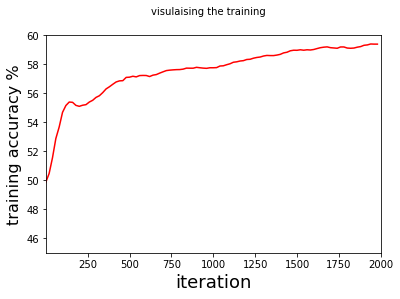

In [54]:
fig = plt.figure()
plt.plot(iteration, train_accuracy, 'r-')
fig.suptitle('visulaising the training', fontsize=10)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('training accuracy %', fontsize=16)
plt.xlim(1, 2000)
plt.ylim(45, 60)
# fig.savefig('test.jpg')
plt.show()